<a href="https://colab.research.google.com/github/q-maze/location-affordability-tool/blob/main/Geopandas_for_User_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive') #authorization code

Mounted at /content/drive


In [27]:
!pip install geopandas
import geopandas

In [28]:
!pip install mapclassify
from mapclassify import __version__ as mc_version

In [34]:
import matplotlib.pyplot as plt

In [44]:


class LocationAffordabilityIndex:
    # constructor for class, takes one argument csv_file_path
    # if filepath variable is not supplied, retrieves fresh csv from URL
    def __init__(self, lai_data_loc='https://opendata.arcgis.com/datasets/8eaa0b89826244ae9246915199462328_0.csv',
                 fips_d_loc='https://www2.census.gov/programs-surveys/popest/geographies/2016/all-geocodes-v2016.xlsx'):
        self.lai_csv_file_path = lai_data_loc
        self.fips_data_file_path = fips_d_loc

        # read in LAI data from chosen data source
        self.df = pd.read_csv(self.lai_csv_file_path)

        # format the LAI data for state and county to match formatting from country fips data set
        self.df['BlockGroups_COUNTYFP10'] = self.df['BlockGroups_COUNTYFP10'].astype(str)
        self.df['BlockGroups_STATEFP10'] = self.df['BlockGroups_STATEFP10'].astype(str)
        self.df['BlockGroups_COUNTYFP10'] = self.df['BlockGroups_COUNTYFP10'].apply(lambda x: x.zfill(3))
        self.df['BlockGroups_STATEFP10'] = self.df['BlockGroups_STATEFP10'].apply(lambda x: x.zfill(2))
        # then add a column concat of the state and county
        self.df['State-County'] = self.df['BlockGroups_STATEFP10'] + self.df['BlockGroups_COUNTYFP10']

        # merge the two data sets
        fips = self.get_county_names()
        self.df = self.df.merge(fips, how='left',
                                on='State-County')
        self.user = None
        self.by_county = None

    # function to output current main dataframe to a csv file in the local directory
    def to_csv(self, filename='LAI.csv'):
        self.df.to_csv(filename)

    # function to create a smaller csv (500 lines) of random lines from df in the local directory
    def to_smaller_csv(self, filename='smaller_LAI.csv'):
        smaller_df = self.df.sample(n=500)
        smaller_df.to_csv(filename)

    def store_fips(self):
        fips = self.get_county_names()
        fips.to_excel('all-geocodes-v2016.xlsx')

    # Returns a dataframe containing FIPS State-County Code and associated county name
    def get_county_names(self):
        # read in the excel file from the supplied location or if none supplied, Census URL
        if self.fips_data_file_path.endswith('.xlsx'):
            fips_df = pd.read_excel(self.fips_data_file_path,
                                    header=None,
                                    index_col=None,
                                    engine='openpyxl')
        else:
            fips_df = pd.read_csv(self.fips_data_file_path)
        # rename the columns to something nice
        # NOTE: ALL COLUMNS LABELED IN CASE WE WANT TO ADD FINER DETAIL (PLACE, CITY) TO APPLICATION LATER
        fips_df.columns = ['Sum_Lvl', 'State',
                           'County', 'Subdivision',
                           'Place', 'City',
                           'Area_Name']
        fips_df = fips_df.iloc[6:].reset_index()  # chop off the info rows at top of document

        # Queries the dataframe to only show the county names (can be removed for places later if needed)
        fips_df = fips_df.query('Sum_Lvl == "050" & Subdivision == "00000" & Place == "00000" & City == "00000"')
        fips_df = fips_df.iloc[:, 1:8].reset_index()
        # creates a state-county concatenation to search in LAI data
        fips_df['State-County'] = fips_df['State'] + fips_df['County']
        # returns only the state-county and area_name, which in this config is only the county names
        fips_df = fips_df[['State-County', 'Area_Name']].copy()
        return fips_df

    # adds a user profile column indicating if each area is affordable for the user to live in
    # we defined affordability to be if the median income in the area for the users classification was less than
    # 120% of the users income
    def add_user_prof(self, user):
        self.user = user
        self.by_county = self.df.groupby(['SF1_BlockGroups_ST_ABBREV','State-County']).mean().reset_index()
        self.by_county['affordable_area'] = np.where(
            self.by_county['hh_' + self.user.classification + '_income'] > self.user.income * 1.2,
            'na',
            'a')

    def show_affordable_locations(self):
        # columns to be returned to all users regardless of classification
        global_result_columns = ['SF1_BlockGroups_STATE_NAME',
                                 'SF1_BlockGroups_ST_ABBREV',
                                 'Area_Name',
                                 'affordable_area',
                                 'residential_density',
                                 'gross_hh_density',
                                 'block_denstiy',
                                 'intersection_density',
                                 'employment_access_index',
                                 'job_diversity_index',
                                 'average_median_commute_distance',
                                 'per_capita_income',
                                 'State-County']
        # makes a copy of the by_county instance variable to work on
        result_df = self.by_county
        # selects only the state the user is interested in and only the areas which have been deemed affordable
        result_df = result_df[result_df['SF1_BlockGroups_ST_ABBREV'] == self.user.state]
        result_df = result_df[result_df['affordable_area'] == 'a']
        # creates a list of columns that containt the user's classification (type1, 7, 8)
        user_classification_cols = [col for col in result_df.columns if self.user.classification in col]
        # creates a list of all columns to be returned
        result_columns = global_result_columns + user_classification_cols
        # adds the columns to the result dataframe
        result_df = result_df[result_df.columns & result_columns]
        # creates a county 
        #result_df['county'] = result_df['State-County'].str[-3:] not needed at moment due to State-County merge with geopandas
        # sorts by per capita income
        result_df = result_df.sort_values(by='per_capita_income')
        return result_df
class LAIUser:
    # receives user input from strings and saves them to instance variables
    def __init__(self, state, income, living, work, household, transport):
        self.state = state
        self.income = income
        self.living = living
        self.work = work
        self.household = household
        self.transport = transport
        self.classification = None

    # classifies a user as single, retired or dual income.
    # classifies user into one of the following types:
    # type 1 - Dual Income
    # type 7 - Single Worker
    # type 8 - Retirees
    def classify_user(self):
        if self.work == 'no':
            if self.household == 'single':
                self.classification = 'type7'
            else:
                self.classification = 'type1'
        else:
            self.classification = 'type8'

def get_filters():
    state_data = {'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AZ', 'california': 'CA',
                  "colorado": 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
                  'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA', 'kansas': 'KS',
                  'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
                  'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
                  'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'New Hampshire': 'NH',
                  'new jersey': 'NJ', 'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC',
                  'north dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK', 'oregon': 'OR',
                  'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC', 'south dakota': 'SD',
                  'tennesee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA',
                  'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY', 'washington dc': 'dc'}
    # Grab all inputs of the user
    print('Hello! Let\'s find you an affordable place!')
    # Get user's State
    while True:
        try:
            state = str(input('Please enter a State you are interested in: ').lower())
            if state in state_data.keys():
                state = state_data.get(state)
                break
            print("Please enter a valid state")
        except Exception as e:
            print(e)

    # Get user income level
    while True:
        try:
            income = int(input('Please enter your income: '))
            if income >= 0:
                break
            print("Please enter a valid income")
        except Exception as e:
            print(e)

    # Are you planning on owning a home or renting
    while True:
        try:
            living = str(input('Are you planning on Renting or Owning a Home?\
            \nEnter Renting or Owning: ').lower())
            if living == 'renting' or living == 'owning':
                break
            print("Invalid Answer Entered")
        except Exception as e:
            print(e)

    # Are you Retired or Working
    while True:
        try:
            work = str(input('Are you Retired?\
            \nEnter Yes or No: ').lower())
            if work == 'yes' or work == 'no':
                break
            print("Invalid Answer Entered")
        except Exception as e:
            print(e)

    # If not retired, type of household
    if work == 'no':
        while True:
            try:
                household = str(input('Single or Dual Income?\
                \nEnter Single or Dual: ').lower())
                if household == 'single' or household == 'dual':
                    break
                print("Invalid Answer Entered")
            except Exception as e:
                print(e)
    else:
        household = 'retired'

    # Prefer Public Transit or Driving
    while True:
        try:
            transport = str(input('Do you prefer Public Transit or Driving?\
            \nEnter Public Transit or Driving: ').lower())
            if transport == 'public transit' or transport == 'driving':
                break
            print("Invalid Answer Entered")
        except Exception as e:
            print(e)

    print('-' * 40)

    user = LAIUser(state, income, living, work, household, transport)
    user.classify_user()

    return user


In [48]:
LAI = LocationAffordabilityIndex()

In [59]:
user = get_filters()

Hello! Let's find you an affordable place!
Please enter a State you are interested in: virginia
Please enter your income: 1000000
Are you planning on Renting or Owning a Home?            
Enter Renting or Owning: Owning
Are you Retired?            
Enter Yes or No: yes
Do you prefer Public Transit or Driving?            
Enter Public Transit or Driving: driving
----------------------------------------


In [60]:
LAI.add_user_prof(user)
result = LAI.show_affordable_locations()

In [13]:
file = 'https://opendata.arcgis.com/datasets/8eaa0b89826244ae9246915199462328_0.csv'
data = pd.read_csv(file)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219829 entries, 0 to 219828
Columns: 123 entries, FID to SHAPE_Area
dtypes: float64(115), int64(6), object(2)
memory usage: 206.3+ MB
None


In [64]:
# path of the county shapefile 
path='/content/drive/MyDrive/CountyShapefile' # change based on where user Shapefiles are saved

# load the shape file using geopandas
geo_county = geopandas.read_file(path)

# rename columns
geo_county.columns=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'State-County', 'county', 'LSAD',
       'ALAND', 'AWATER', 'geometry']

geo_county['State-County'] = pd.to_numeric(geo_county["State-County"], downcast='integer')
result['State-County'] = pd.to_numeric(result["State-County"], downcast='integer')

# merge cb_2016_us_county_20m file with usa dta 
geo_county=geo_county.merge(result,on='State-County').dropna(axis=0).sort_values(by='per_capita_income',ascending=False).reset_index()
geo_county.tail()

,index,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,State-County,county,LSAD,ALAND,AWATER,geometry,SF1_BlockGroups_ST_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,affordable_area
81,119,51,089,01502770,0500000US51089,51089,Henry,06,990272713,5281696,"POLYGON ((-80.09439 36.77955, -80.04149 36.794...",VA,1.259702,0.228902,0.018971,0.068895,3265.507475,2257.968477,9.318480,14879.384611,26913.6,2.0,0.0,64.912217,36.504192,69.008735,40.600710,52.476206,24.068181,28.408025,1.370085,14859.151442,32.044538,a
82,46,51,169,01498172,0500000US51169,51169,Scott,06,1387008855,8060238,"POLYGON ((-82.94754 36.67584, -82.82316 36.733...",VA,1.074918,0.061446,0.010289,0.037336,2264.149720,2394.549566,14.623991,14496.867964,30199.2,2.0,0.0,62.685457,30.993165,67.692898,36.000603,48.143602,16.451307,31.692294,1.571263,21138.585702,2.399969,a
83,4,51,590,01498421,0500000US51590,51590,Danville,25,111136851,2536146,"POLYGON ((-79.50110 36.61825, -79.42210 36.600...",VA,2.023034,1.369233,0.089351,0.233566,8767.467588,2863.534141,10.056169,14223.501075,28039.2,2.0,0.0,57.538620,34.599230,65.444089,42.504698,48.291402,25.352012,22.939390,1.186717,11881.832184,39.365775,a
84,49,51,730,01498435,0500000US51730,51730,Petersburg,25,59430127,614559,"POLYGON ((-77.44752 37.22271, -77.41651 37.233...",VA,2.268325,1.551451,0.154694,0.330910,9345.350665,2585.351305,15.674679,14069.026165,46034.4,2.0,0.0,42.043601,25.635252,48.320961,31.912613,36.756543,20.348194,16.408349,1.331643,13841.427467,36.678991,a
85,10,51,183,01690257,0500000US51183,51183,Sussex,06,1269664389,6755317,"POLYGON ((-77.61903 36.87784, -77.39850 36.992...",VA,1.131064,0.027536,0.009128,0.023925,2062.369450,2213.245231,26.661140,13761.609758,46034.4,2.0,0.0,53.071336,29.104007,59.450355,35.483023,39.930872,15.963543,23.967328,1.759254,23686.504498,0.000000,a


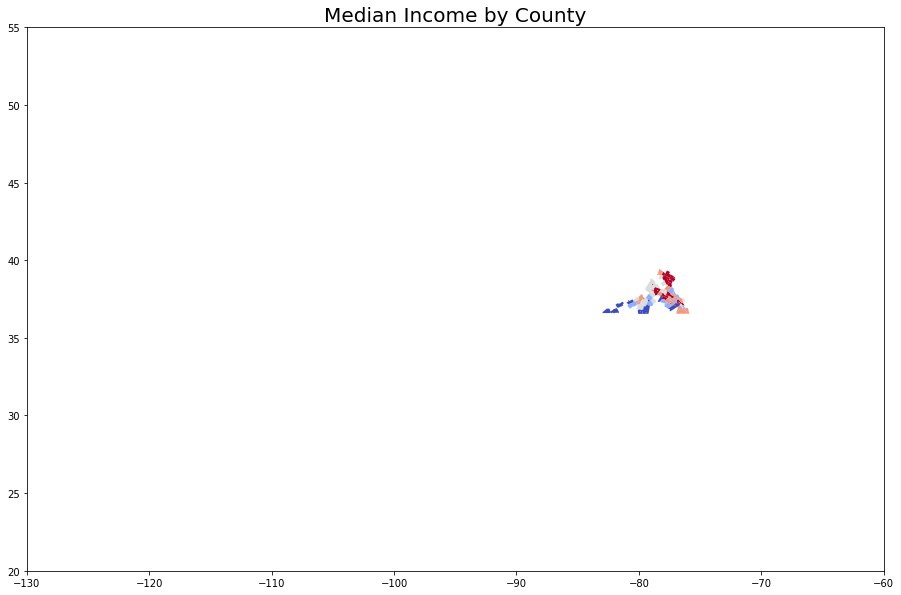

In [63]:
# plot
geo_county.plot(column='per_capita_income',scheme="quantiles",figsize=(25,10),cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Median Income by County',fontsize=20)
# add state borders
# zoom on state
plt.show()